I used flickrfaceshq-dataset-ffhq dataset from kaggle. Please Ignore these few lines!

In [1]:
! pip install -q kaggle


In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gowtham4204","key":"9a6939f88e720ec692bd009f08447a02"}'}

In [3]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

In [8]:
! mkdir ~/.dataset

In [5]:
!kaggle datasets download -d arnaud58/flickrfaceshq-dataset-ffhq

100% 19.5G/19.5G [03:20<00:00, 65.9MB/s]
100% 19.5G/19.5G [03:20<00:00, 104MB/s] 


In [6]:
!unzip /content/flickrfaceshq-dataset-ffhq.zip -d /content/flickrfaceshq-dataset-ffhq/

Streaming output truncated to the last 5000 lines.
  inflating: /content/flickrfaceshq-dataset-ffhq/49001.png  
  inflating: /content/flickrfaceshq-dataset-ffhq/49002.png  
  inflating: /content/flickrfaceshq-dataset-ffhq/49003.png  
  inflating: /content/flickrfaceshq-dataset-ffhq/49004.png  
  inflating: /content/flickrfaceshq-dataset-ffhq/49005.png  
  inflating: /content/flickrfaceshq-dataset-ffhq/49006.png  
  inflating: /content/flickrfaceshq-dataset-ffhq/49007.png  
  inflating: /content/flickrfaceshq-dataset-ffhq/49008.png  
  inflating: /content/flickrfaceshq-dataset-ffhq/49009.png  
  inflating: /content/flickrfaceshq-dataset-ffhq/49010.png  
  inflating: /content/flickrfaceshq-dataset-ffhq/49011.png  
  inflating: /content/flickrfaceshq-dataset-ffhq/49012.png  
  inflating: /content/flickrfaceshq-dataset-ffhq/49013.png  
  inflating: /content/flickrfaceshq-dataset-ffhq/49014.png  
  inflating: /content/flickrfaceshq-dataset-ffhq/49015.png  
  inflating: /content/flickrfacesh

In [7]:
!pip install keras

# Deep Learning Intern Assignment
## Category selected: People faces.

Importing packages

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
import os

# Enable eager execution
tf.compat.v1.enable_eager_execution(
    config=None, device_policy=None, execution_mode=None
)

Only using 1000 images as said in the task.

In [13]:
# Load and preprocess the images
data_path = '/content/flickrfaceshq-dataset-ffhq'
image_size = (64, 64)
batch_size = 64

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = (image - 127.5) / 127.5  # Normalize to the range [-1, 1]
    return image

# Create a dataset
image_paths = [os.path.join(data_path, filename) for filename in os.listdir(data_path)[:1000]]
dataset = tf.data.Dataset.from_tensor_slices(image_paths)
dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(1000).batch(batch_size)


In [14]:
print(dataset)

<_BatchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>


Building the model. First I took a very simple model without any hyperparameter tuning just to give the demo of GAN.

In [15]:

# Generator
def build_generator(noise_dim):
    model = models.Sequential()
    model.add(layers.Dense(8 * 8 * 256, input_dim=noise_dim))
    model.add(layers.Reshape((8, 8, 256)))
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', activation='relu'))
    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', activation='relu'))
    model.add(layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', activation='tanh'))
    return model


# Discriminator
def build_discriminator(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

input_shape = (64, 64, 3)
noise_dim = 100
generator = build_generator(noise_dim)
discriminator = build_discriminator(input_shape)


Compiling the model and parameters

In [17]:
discriminator.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])

# The generator input
# noise_dim = 100
generator_input = layers.Input(shape=(noise_dim,))

# Build the GAN
gen_output = generator(generator_input)
discriminator.trainable = False
gan_output = discriminator(gen_output)

gan = models.Model(generator_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(0.0002, 0.5))

Function to see some sample generator images.

In [18]:
def sample_images(generator, epoch):
    r, c = 5, 5  # Number of rows and columns for the grid of images
    noise = np.random.normal(0, 1, (r * c, noise_dim))  # Generate random noise
    gen_images = generator.predict(noise)  # Generate images using the generator
    gen_images = 0.5 * gen_images + 0.5  # De-normalize images to [0, 1] range

    fig, axs = plt.subplots(r, c, figsize=(10, 10))  # Create a grid of subplots
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_images[cnt])  # Display the generated image
            axs[i, j].axis('off')  # Turn off axis labels
            cnt += 1

    fig.savefig(f"images/gen_{epoch}.png")  # Save the figure with generated images
    plt.close()

While training we can't figure out GAN's models accuracy for sure! So losses of generator and discriminator are gonna be aiding us.

In [21]:


d_losses = []
g_losses = []

# Training loop
epochs = 50
sample_interval = 50
dataset_size = 1000
for epoch in range(epochs):
    for batch_images in dataset:

        batch_size = batch_images.shape[0]  # Get the batch size
        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        gen_images = generator.predict(noise)
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))

        d_loss_real = discriminator.train_on_batch(batch_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(gen_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        g_loss = gan.train_on_batch(noise, real_labels)
        d_losses.append(d_loss[0])
        g_losses.append(g_loss)
    if epoch % sample_interval == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss}")





2/2 [==============================] - 0s 36ms/step
Epoch 0, D Loss: 0.2989605301991105, G Loss: 0.8595554232597351
2/2 [==============================] - 0s 41ms/step


Losses can be seen in the graph.

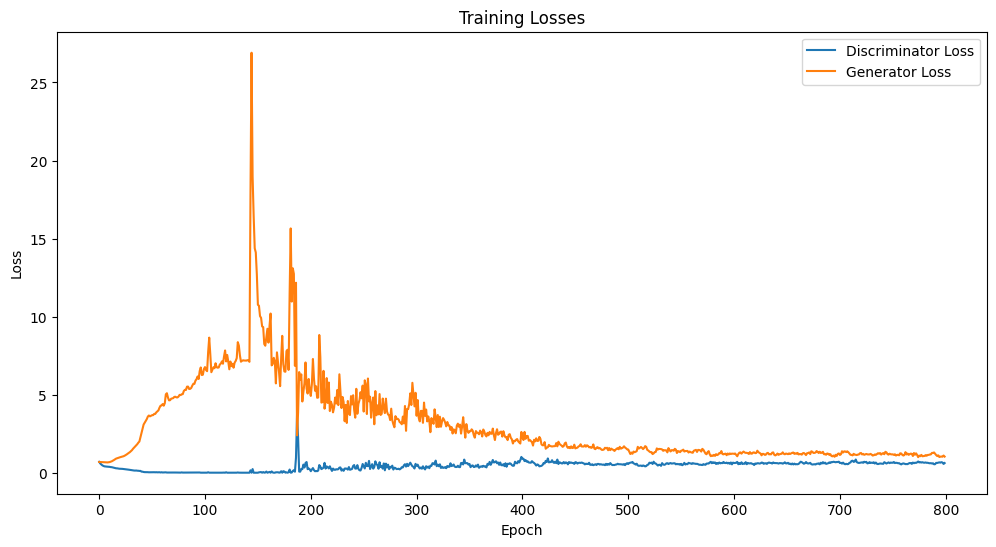

In [22]:
import matplotlib.pyplot as plt

# Train the model and store the history

plt.figure(figsize=(12, 6))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()


Sample Images are not that good but can be improved further more with more playing with the model.

1/1 [==============================] - 0s 109ms/step


FileNotFoundError: ignored

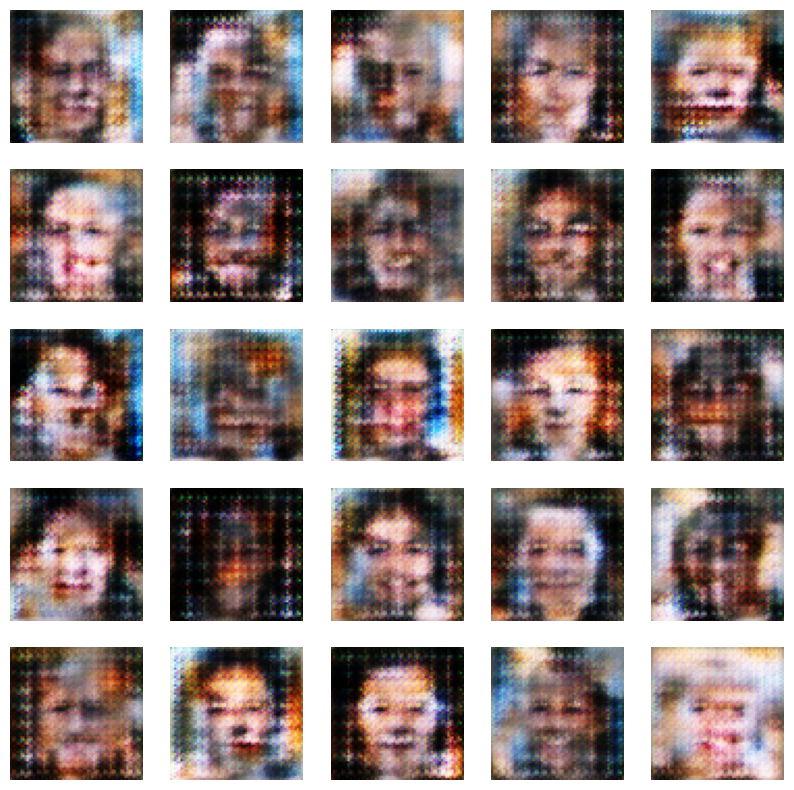

In [24]:
sample_images(generator, epoch)

I have done 100 epochs too. The results are asusual.

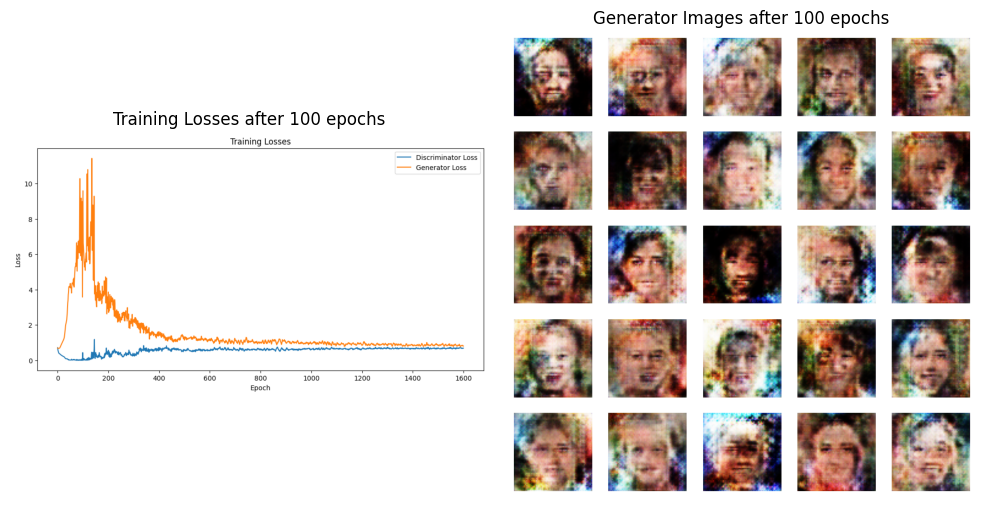

In [4]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the images using matplotlib
image_path1 = 'C:/Users/gowth/Downloads/100.png'  # Replace with the actual path to your first image
image_path2 = 'C:/Users/gowth/Downloads/1001.png'  # Replace with the actual path to your second image

img1 = mpimg.imread(image_path1)
img2 = mpimg.imread(image_path2)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Display the images
ax1.imshow(img1)
ax1.axis('off')  # Turn off axis numbers and ticks
ax1.set_title('Training Losses after 100 epochs')

ax2.imshow(img2)
ax2.axis('off')  # Turn off axis numbers and ticks
ax2.set_title('Generator Images after 100 epochs')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [25]:
generator.save('/content/models')

Saving the output Images for metrics calculation.

In [26]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the trained generator model
# Replace this with your actual generator loading code
generator = tf.keras.models.load_model('/content/models')

# Define the evaluation noise dimension
latent_dim = 100
num_generated_images = 100
evaluation_noise = tf.random.normal([num_generated_images, latent_dim])

# Generate images using the trained generator
generated_images = generator.predict(evaluation_noise, batch_size=num_generated_images)

# Specify the directory to save the evaluation images
save_dir = '/content/eval_images'

# Create the save directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the generated evaluation images
for i, image in enumerate(generated_images):
    filename = f'eval_image_{i}.png'  # Change the naming convention if needed
    save_path = os.path.join(save_dir, filename)
    plt.imsave(save_path, (image + 1) / 2)  # Scale and save the image

print("Generated evaluation images saved.")


1/1 [==============================] - 1s 552ms/step
Generated evaluation images saved.


Calculation of Frechet Inception Distance score Score And Inception Score

In [28]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

# Load the trained generator model
# Replace this with your actual generator loading code
generator = tf.keras.models.load_model('/content/models')

# Define the evaluation noise dimension
latent_dim = 100
num_generated_images = 100
evaluation_noise = tf.random.normal([num_generated_images, latent_dim])

# Generate images using the trained generator
generated_images = generator(evaluation_noise, training=False)

# Load and preprocess a set of real images for evaluation
eval_data_dir = '/content/eval_images'  # Directory containing real images for evaluation
eval_image_paths = [os.path.join(eval_data_dir, filename) for filename in os.listdir(eval_data_dir)[:100]]

eval_images = []
for path in eval_image_paths:
    img = load_img(path, target_size=(299, 299))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
    eval_images.append(img_array)

eval_images = np.array(eval_images)

resized_generated_images = tf.image.resize(generated_images, (299, 299), method=tf.image.ResizeMethod.BICUBIC)

# Calculate FID manually
def calculate_fid(real_images, generated_images):
    mean_real = np.mean(real_images, axis=(0, 1, 2))
    mean_generated = np.mean(generated_images, axis=(0, 1, 2))
    cov_real = np.cov(np.reshape(real_images, (-1, real_images.shape[-1])), rowvar=False)
    cov_generated = np.cov(np.reshape(generated_images, (-1, generated_images.shape[-1])), rowvar=False)

    diff = mean_real - mean_generated
    covmean = np.sqrt(cov_real.dot(cov_generated))

    # Calculate FID score
    fid = np.dot(diff, diff) + np.trace(cov_real + cov_generated - 2 * covmean)
    return fid

# Calculate Inception Score
def calculate_is(images, splits=10):
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
    activations = model.predict(images)

    # Normalize activations
    activations /= np.linalg.norm(activations, axis=1, keepdims=True)

    # Split activations into subgroups
    split_size = activations.shape[0] // splits
    is_scores = []

    for i in range(splits):
        split_activations = activations[i * split_size : (i + 1) * split_size]
        epsilon = 1e-20  # Small constant to avoid zero values
        split_activations += epsilon
        kl_divergences = split_activations * (np.log(split_activations) - np.log(np.expand_dims(np.mean(split_activations, axis=0), 0)))
        kl_divergences = np.mean(np.sum(kl_divergences, axis=1))
        is_score = np.exp(kl_divergences)
        is_scores.append(is_score)

    final_is_score = np.mean(is_scores)
    return final_is_score

# Evaluate FID and IS
fid_score = calculate_fid(eval_images, resized_generated_images.numpy())
is_score = calculate_is(resized_generated_images.numpy())
print(f"FID Score: {fid_score}, IS Score: {is_score}")


4/4 [==============================] - 17s 4s/step
FID Score: 0.786239915152043, IS Score: 640.4481811523438


FID score must be low but the our fid is not that much low.
IS score must be very high but here it's not that much high.
So, It is clear that model must be upgraded again to acheive further good results.

## Model Deployment
I don't have experience in this but willing to learn. If I make mistakes, please don't forget the fact that I never used any of flask and aws.

In [ ]:
pip install Flask

In [ ]:
import os
import numpy as np
from flask import Flask, request, jsonify
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input

app = Flask(__name__)

# Load the generator model
model_path = '/content/models'  # Replace with the actual path
generator = load_model(model_path)

noise_dim = 100

@app.route('/generate', methods=['POST'])
def generate_image():
    try:
        data = request.get_json()
        num_images = data.get('num_images', 1)

        generated_images = []
        for _ in range(num_images):
            noise = np.random.normal(0, 1, (1, noise_dim))
            gen_image = generator.predict(noise)[0]
            generated_images.append(gen_image.tolist())

        response = {'images': generated_images}
        return jsonify(response)

    except Exception as e:
        return jsonify({'error': str(e)}), 500

if __name__ == '__main__':
    app.run(debug=True)


In [ ]:
pip install zappa

In [ ]:
zappa deploy

In [ ]:
import requests

data = {'num_images': 5}  # Number of images to generate
response = requests.post('API_ENDPOINT_URL', json=data)
generated_images = response.json()['images']


Thank you for considering my application.